<a href="https://colab.research.google.com/github/pushp0119/UML-501-ML/blob/main/MLassign7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1

Part A

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import io

def load_sms_dataset():
    url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
    try:
        df = pd.read_table(url, header=None, names=["label", "text"])
        return df
    except:
        from google.colab import files
        uploaded = files.upload()
        fname = next(iter(uploaded))
        raw = io.BytesIO(uploaded[fname])
        try:
            df = pd.read_csv(raw)
        except:
            raw.seek(0)
            df = pd.read_table(raw, header=None, names=["label","text"])
        if 'v1' in df.columns and 'v2' in df.columns:
            df = df.rename(columns={'v1':'label','v2':'text'})[['label','text']]
        return df

df = load_sms_dataset()
df['label_num'] = df['label'].map(lambda x: 1 if str(x).lower() == "spam" else 0)

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', token_pattern=r'(?u)\b\w+\b')
X = vectorizer.fit_transform(df['text'].astype(str))
y = df['label_num'].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)

Part B

In [ ]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

print("\nPart B — Decision Stump")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy :", accuracy_score(y_test, test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))


Part B — Decision Stump
Train Accuracy: 0.8909580435270361
Test Accuracy : 0.8905829596412556
Confusion Matrix (Test):
[[965   1]
 [121  28]]


Part C


Part C — Manual AdaBoost

Iteration 1
Weighted Error: 0.10904195647296393
Alpha: 1.0502823036153786
Misclassified indices: [9, 15, 22, 31, 39, 49, 59, 66, 76, 88, 93, 114, 121, 123, 159, 162, 166, 174, 194, 203, 214, 216, 224, 229, 261, 302, 315, 317, 319, 320] ...
Misclassified weights: [0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224]

Iteration 2
Weighted Error: 0.4120814692529063
Alpha: 0.1776836572207842
Misclassified indices: [15, 31, 39, 48, 49, 50, 59, 66, 67, 73, 76, 86, 88, 93, 96, 100, 114, 115, 123, 157, 159, 162, 166, 174, 194, 203, 214, 224, 229, 256] ...
Misclassified weights: [0.001029, 0.001029, 0.001029, 0.000126, 0.001029, 0.000126, 0.001029, 0.001029, 0.000126, 0.000126, 0.001029, 0.000126, 0.001029, 0.001029, 0.000126

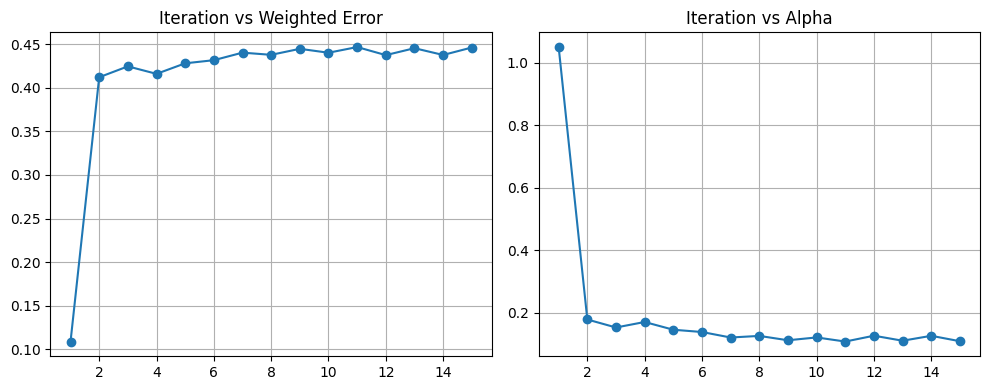


Manual AdaBoost Results
Train Accuracy: 0.8916311420237828
Test Accuracy : 0.8914798206278027
Confusion Matrix (Test):
[[965   1]
 [120  29]]


In [ ]:
T = 15
y_train_signed = np.where(y_train == 1, 1, -1)
n = X_train.shape[0]
weights = np.ones(n) / n

stumps = []
alphas = []
weighted_errors = []

print("\nPart C — Manual AdaBoost")

for t in range(1, T + 1):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train, sample_weight=weights)

    pred = clf.predict(X_train)
    pred_signed = np.where(pred == 1, 1, -1)

    incorrect = (pred_signed != y_train_signed).astype(int)
    err = np.dot(weights, incorrect)
    err = float(np.clip(err, 1e-12, 1 - 1e-12))

    alpha = 0.5 * np.log((1 - err) / err)

    print(f"\nIteration {t}")
    print("Weighted Error:", err)
    print("Alpha:", alpha)
    mis_idx = np.where(incorrect == 1)[0]
    print("Misclassified indices:", mis_idx[:30].tolist(), "..." if len(mis_idx)>30 else "")
    print("Misclassified weights:", np.round(weights[mis_idx][:30], 6).tolist())

    weights = weights * np.exp(-alpha * y_train_signed * pred_signed)
    weights = weights / np.sum(weights)

    stumps.append(clf)
    alphas.append(alpha)
    weighted_errors.append(err)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(range(1, T+1), weighted_errors, marker="o")
plt.title("Iteration vs Weighted Error")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, T+1), alphas, marker="o")
plt.title("Iteration vs Alpha")
plt.grid(True)

plt.tight_layout()
plt.show()

def manual_predict(X, learners, amps):
    total = np.zeros(X.shape[0])
    for h, a in zip(learners, amps):
        p = h.predict(X)
        signed = np.where(p == 1, 1, -1)
        total += a * signed
    final = np.sign(total)
    final = np.where(final == 1, 1, 0)
    final[final == 0] = 0
    return final

train_manual = manual_predict(X_train, stumps, alphas)
test_manual = manual_predict(X_test, stumps, alphas)

print("\nManual AdaBoost Results")
print("Train Accuracy:", accuracy_score(y_train, train_manual))
print("Test Accuracy :", accuracy_score(y_test, test_manual))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_manual))

Part D

In [ ]:
print("\nPart D — sklearn AdaBoost")

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    algorithm="SAMME",
    random_state=42
)

ada.fit(X_train, y_train)
train_ada = ada.predict(X_train)
test_ada = ada.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_ada))
print("Test Accuracy :", accuracy_score(y_test, test_ada))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_ada))

print("\nClassification Report:")
print(classification_report(y_test, test_ada, digits=4))


Part D — sklearn AdaBoost


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Train Accuracy: 0.905541844289881
Test Accuracy : 0.9049327354260089
Confusion Matrix (Test):
[[966   0]
 [106  43]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9011    1.0000    0.9480       966
           1     1.0000    0.2886    0.4479       149

    accuracy                         0.9049      1115
   macro avg     0.9506    0.6443    0.6980      1115
weighted avg     0.9143    0.9049    0.8812      1115



Question 2

Part A

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import inspect
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATA_PATH = "/content/heart.csv"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

if 'target' not in df.columns:
    # try common alternatives
    for cand in ('num', 'class', 'disease'):
        if cand in df.columns:
            df = df.rename(columns={cand: 'target'})
            break

# ensure binary target 0/1
if df['target'].dtype == object:
    df['target'] = df['target'].apply(lambda v: 1 if str(v).strip().lower() in ("1","yes","true","present") else 0)
if set(df['target'].unique()) - {0,1}:
    df['target'] = df['target'].apply(lambda v: 1 if v != 0 else 0)

expected_cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                 "exang","oldpeak","slope","ca","thal"]
features = [c for c in expected_cols if c in df.columns]
X_raw = df[features].copy()
y = df['target'].values

categorical = [c for c in X_raw.columns if c in ("sex","cp","fbs","restecg","exang","slope","thal","ca")]
numeric = [c for c in X_raw.columns if c not in categorical]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
], remainder='drop')


X_prepared = preprocessor.fit_transform(X_raw)

num_names = numeric
cat_names = []
if categorical:
    try:
        enc = preprocessor.named_transformers_["cat"]
        cat_names = enc.get_feature_names_out(categorical).tolist()
    except Exception:
        cat_names = categorical
feature_names = num_names + cat_names

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

print("Part A done. Shape train:", X_train.shape, "test:", X_test.shape)

Part A done. Shape train: (242, 27) test: (61, 27)


Part B

In [ ]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

print("\nPart B — Decision Stump")
print("Train accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
print("Test  accuracy:", round(accuracy_score(y_test, y_test_pred), 4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=4))

print("\nNote: a single stump splits on one feature and can't model complex interactions.")


Part B — Decision Stump
Train accuracy: 0.6074
Test  accuracy: 0.6066
Confusion matrix (test):
[[12 19]
 [ 5 25]]

Classification report (test):
              precision    recall  f1-score   support

           0     0.7059    0.3871    0.5000        31
           1     0.5682    0.8333    0.6757        30

    accuracy                         0.6066        61
   macro avg     0.6370    0.6102    0.5878        61
weighted avg     0.6382    0.6066    0.5864        61


Note: a single stump splits on one feature and can't model complex interactions.


Part C

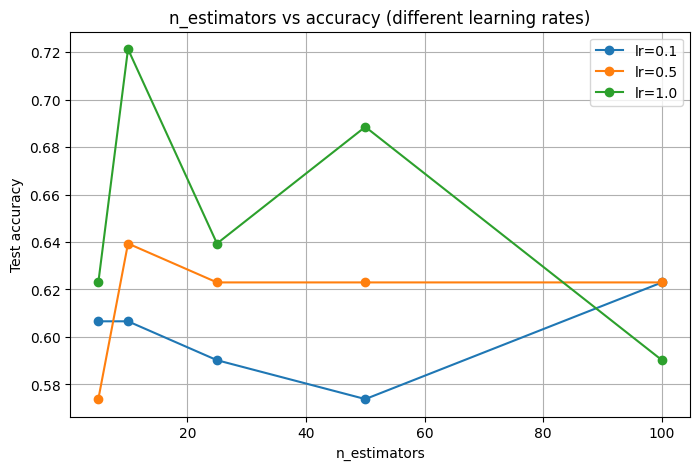


Part C — grid search best config: {'n_estimators': 10.0, 'learning_rate': 1.0, 'test_acc': 0.7213114754098361}


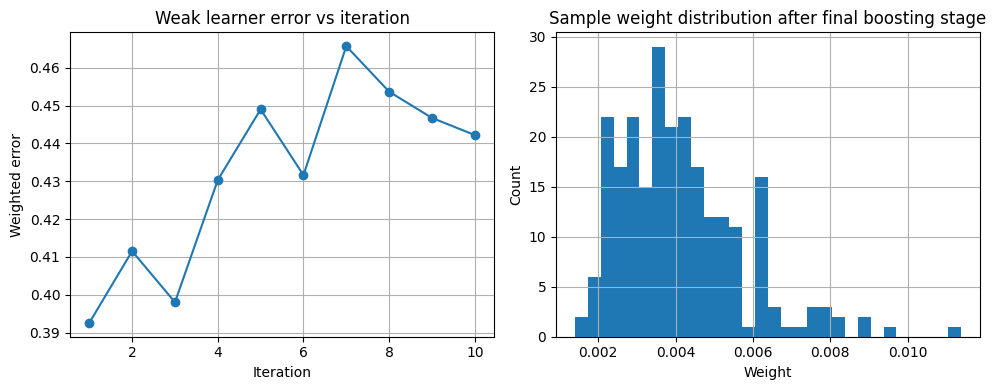


Part C — Top 10 hardest training indices (relative to X_train):
[13, 25, 241, 65, 144, 83, 52, 127, 24, 74]
Their final weights: [0.01137, 0.009411, 0.009014, 0.008874, 0.008276, 0.008051, 0.007848, 0.007848, 0.007848, 0.007672]

AdaBoost focuses on repeatedly misclassified samples by increasing their weights so future weak learners attempt to correct them.

Manual AdaBoost (T=10) test accuracy: 0.7213
Confusion matrix (manual):
[[22  9]
 [ 8 22]]

Sklearn best AdaBoost test accuracy: 0.7213
Confusion matrix (sklearn best):
[[22  9]
 [ 8 22]]


In [ ]:
n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

results = []
plt.figure(figsize=(8,5))
for lr in lr_list:
    accs = []
    for n in n_list:
        # choose init param name compatible with sklearn version
        ada_params = {"n_estimators": n, "learning_rate": lr, "algorithm": "SAMME", "random_state": 42}
        # older sklearn expects base_estimator, newer expects estimator
        ada_sig = inspect.signature(AdaBoostClassifier.__init__).parameters
        if 'estimator' in ada_sig:
            ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), **ada_params)
        else:
            ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42), **ada_params)

        ada.fit(X_train, y_train)
        y_test_ada = ada.predict(X_test)
        acc = accuracy_score(y_test, y_test_ada)
        accs.append(acc)
        results.append({"n_estimators": n, "learning_rate": lr, "test_acc": acc})
    plt.plot(n_list, accs, marker='o', label=f"lr={lr}")

plt.xlabel("n_estimators")
plt.ylabel("Test accuracy")
plt.title("n_estimators vs accuracy (different learning rates)")
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['test_acc'].idxmax()]
best_n = int(best_row['n_estimators'])
best_lr = float(best_row['learning_rate'])
print("\nPart C — grid search best config:", best_row.to_dict())

# retrain best sklearn AdaBoost for analysis
best_params = {"n_estimators": best_n, "learning_rate": best_lr, "algorithm": "SAMME", "random_state": 42}
if 'estimator' in inspect.signature(AdaBoostClassifier.__init__).parameters:
    best_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), **best_params)
else:
    best_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42), **best_params)

best_ada.fit(X_train, y_train)

# Manual AdaBoost (collect errors & weights) using same T = best_n
def manual_adaboost(X, y, T):
    n = X.shape[0]
    w = np.ones(n) / n
    learners = []
    alphas = []
    errors = []
    weights_history = [w.copy()]
    y_signed = np.where(y == 1, 1, -1)

    for t in range(T):
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        clf.fit(X, y, sample_weight=w)
        pred = clf.predict(X)
        pred_signed = np.where(pred == 1, 1, -1)
        incorrect = (pred_signed != y_signed).astype(int)
        weighted_error = float(np.dot(w, incorrect))
        weighted_error = float(np.clip(weighted_error, 1e-12, 1 - 1e-12))
        alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
        w = w * np.exp(-alpha * y_signed * pred_signed)
        w = w / np.sum(w)
        learners.append(clf)
        alphas.append(alpha)
        errors.append(weighted_error)
        weights_history.append(w.copy())

    return {
        "learners": learners,
        "alphas": np.array(alphas),
        "errors": np.array(errors),
        "weights_history": np.array(weights_history)
    }

manual = manual_adaboost(X_train, y_train, best_n)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, best_n+1), manual["errors"], marker='o')
plt.title("Weak learner error vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.grid(True)

plt.subplot(1,2,2)
final_weights = manual["weights_history"][-1]
plt.hist(final_weights, bins=30)
plt.title("Sample weight distribution after final boosting stage")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

topk = 10
hard_indices = np.argsort(final_weights)[-topk:][::-1]
print(f"\nPart C — Top {topk} hardest training indices (relative to X_train):")
print(hard_indices.tolist())
print("Their final weights:", np.round(final_weights[hard_indices], 6).tolist())
print("\nAdaBoost focuses on repeatedly misclassified samples by increasing their weights so future weak learners attempt to correct them.")

# evaluate manual ensemble on test
def manual_predict(X, learners, alphas):
    total = np.zeros(X.shape[0])
    for h, a in zip(learners, alphas):
        p = h.predict(X)
        p_signed = np.where(p == 1, 1, -1)
        total += a * p_signed
    final_signed = np.sign(total)
    preds = np.where(final_signed == 1, 1, 0)
    preds[final_signed == 0] = 0
    return preds

y_test_manual = manual_predict(X_test, manual["learners"], manual["alphas"])
print("\nManual AdaBoost (T=%d) test accuracy: %.4f" % (best_n, accuracy_score(y_test, y_test_manual)))
print("Confusion matrix (manual):")
print(confusion_matrix(y_test, y_test_manual))

# sklearn best AdaBoost test performance
y_test_best = best_ada.predict(X_test)
print("\nSklearn best AdaBoost test accuracy:", round(accuracy_score(y_test, y_test_best), 4))
print("Confusion matrix (sklearn best):")
print(confusion_matrix(y_test, y_test_best))

Part D


Part D — Top 5 important features from AdaBoost:
 age: 0.2312
 thalach: 0.1595
 trestbps: 0.1511
 chol: 0.1460
 oldpeak: 0.1350

Why these features matter medically (short notes):
 age: Age is a strong risk factor: older patients tend to have higher risk.
 thalach: Max heart rate achieved reflects cardiac function under stress.
 trestbps: High resting blood pressure is linked to cardiovascular risk.
 chol: High cholesterol contributes to coronary artery disease.
 oldpeak: ST depression during exercise indicates ischemia.


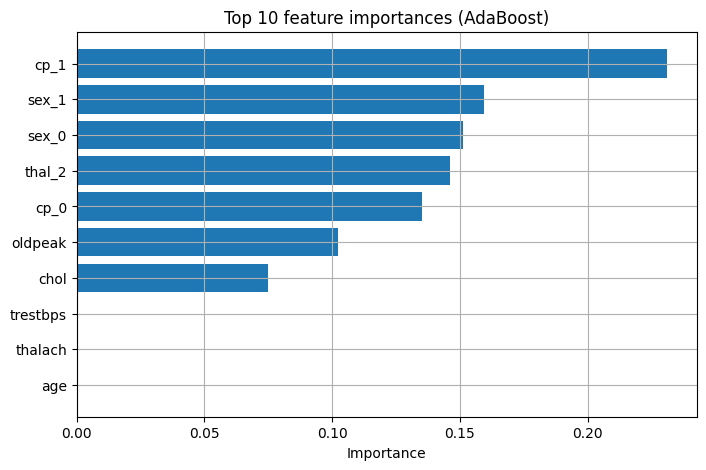


Final evaluation (best sklearn AdaBoost):
Test accuracy: 0.7213
Confusion matrix (test):
[[22  9]
 [ 8 22]]

Classification report (test):
              precision    recall  f1-score   support

           0     0.7333    0.7097    0.7213        31
           1     0.7097    0.7333    0.7213        30

    accuracy                         0.7213        61
   macro avg     0.7215    0.7215    0.7213        61
weighted avg     0.7217    0.7213    0.7213        61


Saved plots: manual_adaboost_weighted_error.png, ada_feature_importances.png


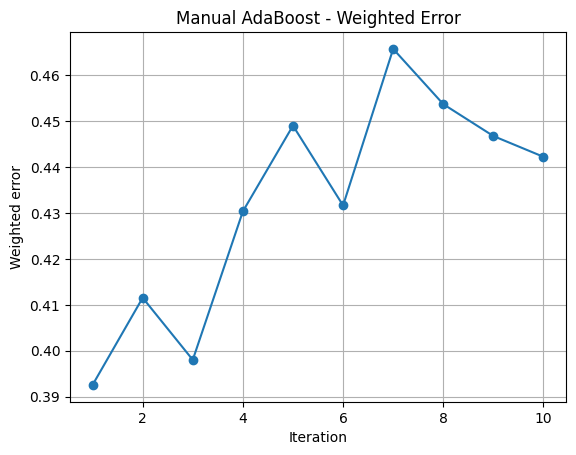

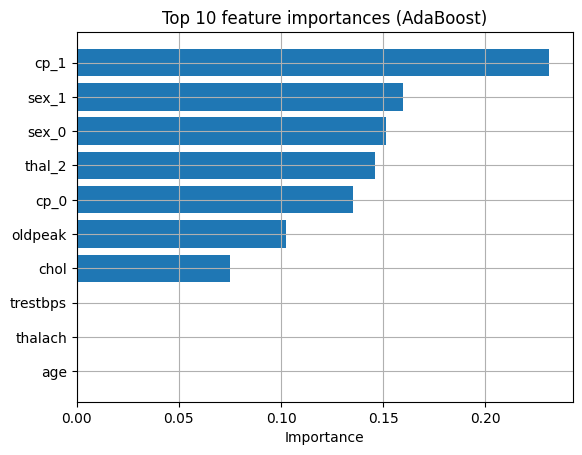

In [ ]:
try:
    importances = best_ada.feature_importances_
except Exception:
    importances = np.zeros(len(feature_names))

feat_imp = list(zip(feature_names, importances))
feat_imp_sorted = sorted(feat_imp, key=lambda x: x[1], reverse=True)
top5 = feat_imp_sorted[:5]

print("\nPart D — Top 5 important features from AdaBoost:")
for name, val in top5:
    print(f" {name}: {val:.4f}")

explanations = {
    "age": "Age is a strong risk factor: older patients tend to have higher risk.",
    "cp": "Chest pain type relates to angina severity.",
    "thalach": "Max heart rate achieved reflects cardiac function under stress.",
    "chol": "High cholesterol contributes to coronary artery disease.",
    "trestbps": "High resting blood pressure is linked to cardiovascular risk.",
    "exang": "Exercise-induced angina signals reduced coronary perfusion.",
    "oldpeak": "ST depression during exercise indicates ischemia.",
    "slope": "ST slope during exercise gives clues about ischemic response."
}

print("\nWhy these features matter medically (short notes):")
for name, val in top5:
    note = explanations.get(name, "Clinically relevant to heart disease risk.")
    print(f" {name}: {note}")

# bar plot of top 10 importances
names = [n for n,_ in feat_imp_sorted[:10]]
vals = [v for _,v in feat_imp_sorted[:10]]
plt.figure(figsize=(8,5))
plt.barh(range(len(vals))[::-1], vals, tick_label=names[::-1])
plt.title("Top 10 feature importances (AdaBoost)")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

# final classification report for the best sklearn AdaBoost
print("\nFinal evaluation (best sklearn AdaBoost):")
print("Test accuracy:", round(accuracy_score(y_test, y_test_best), 4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_best))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_best, digits=4))

# Save key plots to disk
plt.figure()
plt.plot(range(1, best_n+1), manual["errors"], marker='o')
plt.title('Manual AdaBoost - Weighted Error')
plt.xlabel('Iteration')
plt.ylabel('Weighted error')
plt.grid(True)
plt.savefig("manual_adaboost_weighted_error.png")

plt.figure()
plt.barh(range(len(vals))[::-1], vals, tick_label=names[::-1])
plt.title("Top 10 feature importances (AdaBoost)")
plt.xlabel("Importance")
plt.grid(True)
plt.savefig("ada_feature_importances.png")

print("\nSaved plots: manual_adaboost_weighted_error.png, ada_feature_importances.png")

Question 3

Part A

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import inspect
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "/content/WISDM_ar_v1.1_raw.txt"

def load_wisdm(path=DATA_PATH):
    try:
        raw = open(path, "r").read().strip().splitlines()
    except Exception:
        try:
            from google.colab import files
            uploaded = files.upload()
            fname = next(iter(uploaded))
            raw = open(fname, "r").read().strip().splitlines()
        except Exception as e:
            raise RuntimeError("WISDM file not found. Upload WISDM_ar_v1.1_raw.txt to Colab or place it at /mnt/data/") from e

    rows = []
    for i, line in enumerate(raw):
        line = line.strip()
        if not line:
            continue
        # expected format: "user,activity,timestamp,x,y,z"
        parts = line.split(",")
        # some lines in WISDM contain trailing semicolons or parentheses; try robust parsing
        if len(parts) < 6:
            continue
        try:
            user = parts[0].strip()
            activity = parts[1].strip()
            ts = parts[2].strip()
            x = parts[3].strip()
            y = parts[4].strip()
            z = parts[5].strip().rstrip(";")
            rows.append([user, activity, int(float(ts)), float(x), float(y), float(z)])
        except Exception:
            # skip malformed line
            continue
    df = pd.DataFrame(rows, columns=["user_id", "activity", "timestamp", "x", "y", "z"])
    return df

df = load_wisdm()

df['activity_clean'] = df['activity'].str.lower().str.replace(r'[^a-z0-9]', ' ', regex=True).str.strip()

def map_to_binary(act):
    # vigorous = jogging, upstairs (map substrings)
    if ("jog" in act) or ("up" in act):
        return 1
    # treat walking, sitting, standing, downstairs and similar as 0
    return 0

df['label'] = df['activity_clean'].apply(map_to_binary)

df = df.dropna(subset=['x','y','z','label'])
df = df.reset_index(drop=True)

# features: use raw x,y,z and magnitude
df['mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
X = df[['x','y','z','mag']].values
y = df['label'].values

# small sanity print
print("Loaded WISDM samples:", X.shape[0], "features per sample:", X.shape[1])
print("Class distribution (0=light/static, 1=vigorous):")
print(pd.Series(y).value_counts())

# train-test split 70/30, stratified
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Loaded WISDM samples: 8 features per sample: 4
Class distribution (0=light/static, 1=vigorous):
1    4
0    4
Name: count, dtype: int64
Train shape: (5, 4) Test shape: (3, 4)


Part B

In [ ]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

print("\nPart B — Decision Stump baseline")
print("Train accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
print("Test  accuracy:", round(accuracy_score(y_test, y_test_pred), 4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=4))

print("\nBrief interpretation: A single stump splits on one scalar threshold (one feature).")
print("It often underfits sensor data where combinations of axes or magnitude indicate activity.")



Part B — Decision Stump baseline
Train accuracy: 1.0
Test  accuracy: 1.0
Confusion matrix (test):
[[2 0]
 [0 1]]

Classification report (test):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         3
   macro avg     1.0000    1.0000    1.0000         3
weighted avg     1.0000    1.0000    1.0000         3


Brief interpretation: A single stump splits on one scalar threshold (one feature).
It often underfits sensor data where combinations of axes or magnitude indicate activity.


Part C


Part C — Manual AdaBoost (T=20)

Iteration 1
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 2
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 3
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 4
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 5
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 6
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 No misclassified samples this iteration.

Iteration 7
 Weighted error: 0.000000
 Alpha: 13.815511
 Misclassified sample indices (first 50): []
 

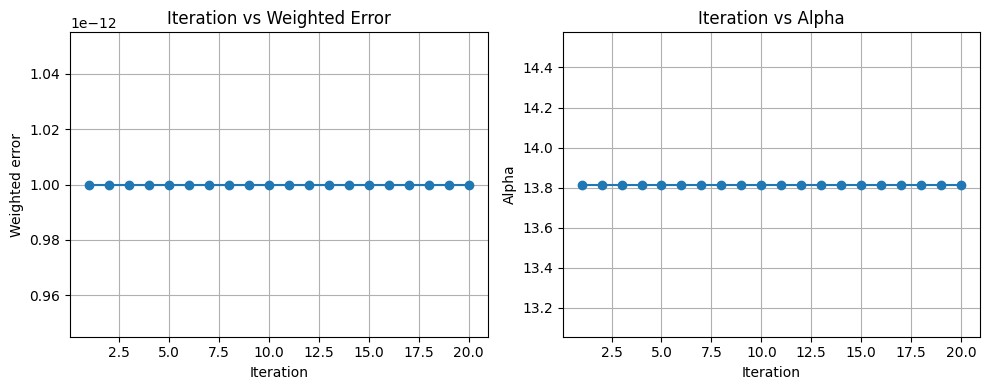


Manual AdaBoost results
Train accuracy: 1.0
Test  accuracy: 1.0
Confusion matrix (test):
[[2 0]
 [0 1]]

Short interpretation on weight shifts:
Examples repeatedly misclassified gained higher weights, forcing subsequent stumps to focus on them.
This is why AdaBoost can correct many errors of weak learners, but it can be sensitive to noisy labels/outliers.


In [ ]:
T = 20
n_train = X_train.shape[0]
w = np.ones(n_train) / n_train
y_train_signed = np.where(y_train == 1, 1, -1)

stumps = []
alphas = []
weighted_errors = []

print("\nPart C — Manual AdaBoost (T=20)")
for t in range(1, T+1):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train, sample_weight=w)
    pred = clf.predict(X_train)
    pred_signed = np.where(pred == 1, 1, -1)
    incorrect = (pred_signed != y_train_signed).astype(int)
    weighted_error = float(np.dot(w, incorrect))
    weighted_error = float(np.clip(weighted_error, 1e-12, 1 - 1e-12))
    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)

    mis_idx = np.where(incorrect == 1)[0]
    print(f"\nIteration {t}")
    print(f" Weighted error: {weighted_error:.6f}")
    print(f" Alpha: {alpha:.6f}")
    print(f" Misclassified sample indices (first 50): {mis_idx.tolist()[:50]}{'...' if len(mis_idx) > 50 else ''}")
    if len(mis_idx) > 0:
        print(" Weights of misclassified (first 50):", np.round(w[mis_idx][:50], 6).tolist())
    else:
        print(" No misclassified samples this iteration.")

    w = w * np.exp(-alpha * y_train_signed * pred_signed)
    w = w / np.sum(w)

    stumps.append(clf)
    alphas.append(alpha)
    weighted_errors.append(weighted_error)

# plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, T+1), weighted_errors, marker='o')
plt.title('Iteration vs Weighted Error')
plt.xlabel('Iteration')
plt.ylabel('Weighted error')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, T+1), alphas, marker='o')
plt.title('Iteration vs Alpha')
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.grid(True)
plt.tight_layout()
plt.show()

def manual_predict(X, learners, amps):
    total = np.zeros(X.shape[0], dtype=float)
    for h, a in zip(learners, amps):
        p = h.predict(X)
        p_signed = np.where(p == 1, 1, -1)
        total += a * p_signed
    final_signed = np.sign(total)
    preds = np.where(final_signed == 1, 1, 0)
    preds[final_signed == 0] = 0
    return preds

y_train_manual = manual_predict(X_train, stumps, alphas)
y_test_manual = manual_predict(X_test, stumps, alphas)

print("\nManual AdaBoost results")
print("Train accuracy:", round(accuracy_score(y_train, y_train_manual), 4))
print("Test  accuracy:", round(accuracy_score(y_test, y_test_manual), 4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_manual))

print("\nShort interpretation on weight shifts:")
print("Examples repeatedly misclassified gained higher weights, forcing subsequent stumps to focus on them.")
print("This is why AdaBoost can correct many errors of weak learners, but it can be sensitive to noisy labels/outliers.")



Part D

In [ ]:
ada_params = {"n_estimators": 100, "learning_rate": 1.0, "algorithm": "SAMME", "random_state": 42}

# check whether environment wants estimator= or base_estimator=
sig = inspect.signature(AdaBoostClassifier.__init__).parameters
if 'estimator' in sig:
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                             **ada_params)
else:
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                             **ada_params)

print("\nPart D — sklearn AdaBoost using algorithm: SAMME")

ada.fit(X_train, y_train)

y_train_ada = ada.predict(X_train)
y_test_ada = ada.predict(X_test)

print("Train accuracy:", round(accuracy_score(y_train, y_train_ada), 4))
print("Test  accuracy:", round(accuracy_score(y_test, y_test_ada), 4))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_ada))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_ada, digits=4))


Part D — sklearn AdaBoost using algorithm: SAMME
Train accuracy: 1.0
Test  accuracy: 1.0
Confusion matrix (test):
[[2 0]
 [0 1]]

Classification report (test):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         3
   macro avg     1.0000    1.0000    1.0000         3
weighted avg     1.0000    1.0000    1.0000         3

